In [125]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format='retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-docgrid")
sns.set_style("darkgrid")

### 4M1

In [2]:
with pm.Model() as m4M1:
    sig = pm.Exponential("sig", lam=1)
    mu = pm.Normal("mu", mu=0, sigma=10)
    y = pm.Normal("y", mu=mu, sigma=sig)

In [3]:
with m4M1:
    idata = pm.sample_prior_predictive()

Sampling: [mu, sig, y]


### 4H1

In [4]:
df = pd.read_csv("../Data/Howell1.csv", delimiter=";")
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [5]:
with pm.Model() as m4H1:
    weight = pm.MutableData("weight", df.weight.values)
    height = pm.MutableData("height", df.height.values)
    alpha = pm.Normal("alpha", mu=0, sigma=100)
    beta = pm.LogNormal("beta", mu=0, sigma=10)
    sigma = pm.Uniform("sigma", lower=0, upper=100)
    mu = alpha + beta*weight
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=height, shape=weight.shape)
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [6]:
weight_test = np.array([46.95, 43.72, 64.78, 32.59, 54.63])

with m4H1:
    pm.set_data({"weight": weight_test})
    y_test = pm.sample_posterior_predictive(idata)

Sampling: [y]


In [7]:
az.rcParams["stats.hdi_prob"] = 0.89
pred_sum = az.summary(y_test.posterior_predictive, kind="stats").reset_index()

In [8]:
out_df = pd.DataFrame({"weight": weight_test})
out_df[["expected height", "hdi_l", "hdi_h"]] = pred_sum.drop(["index", "sd"], axis=1)
out_df

,weight,expected height,hdi_l,hdi_h
0,46.95,158.223,144.114,173.527
1,43.72,152.316,137.654,167.090
2,64.78,189.575,173.959,204.005
3,32.59,132.970,118.997,148.524
4,54.63,171.883,157.352,187.681


### 4H2

In [9]:
df2 = df[df.age < 18]

In [98]:
with pm.Model() as m4H2:
    weight = pm.MutableData("weight", df2.weight.values)
    height = pm.MutableData("height", df2.height.values)
    alpha = pm.Normal("alpha", mu=df2.weight.mean(), sigma=df2.weight.std())
    beta = pm.LogNormal("beta", mu=0, tau=1)
    sigma = pm.Uniform("sigma", lower=0, upper=100)
    mu = pm.Deterministic("mu", alpha + beta*weight) # for plotting hdi of mu
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=height, shape=weight.shape)
    mean_q = pm.find_MAP() # for plotting MAP reg line
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [99]:
az.summary(idata, var_names=["alpha", "beta", "sigma"], kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha,57.43,1.44,55.25,59.87
beta,2.75,0.07,2.65,2.87
sigma,8.54,0.45,7.83,9.26


In [100]:
with m4H2:
    post_pred = pm.sample_posterior_predictive(idata)

Sampling: [y]


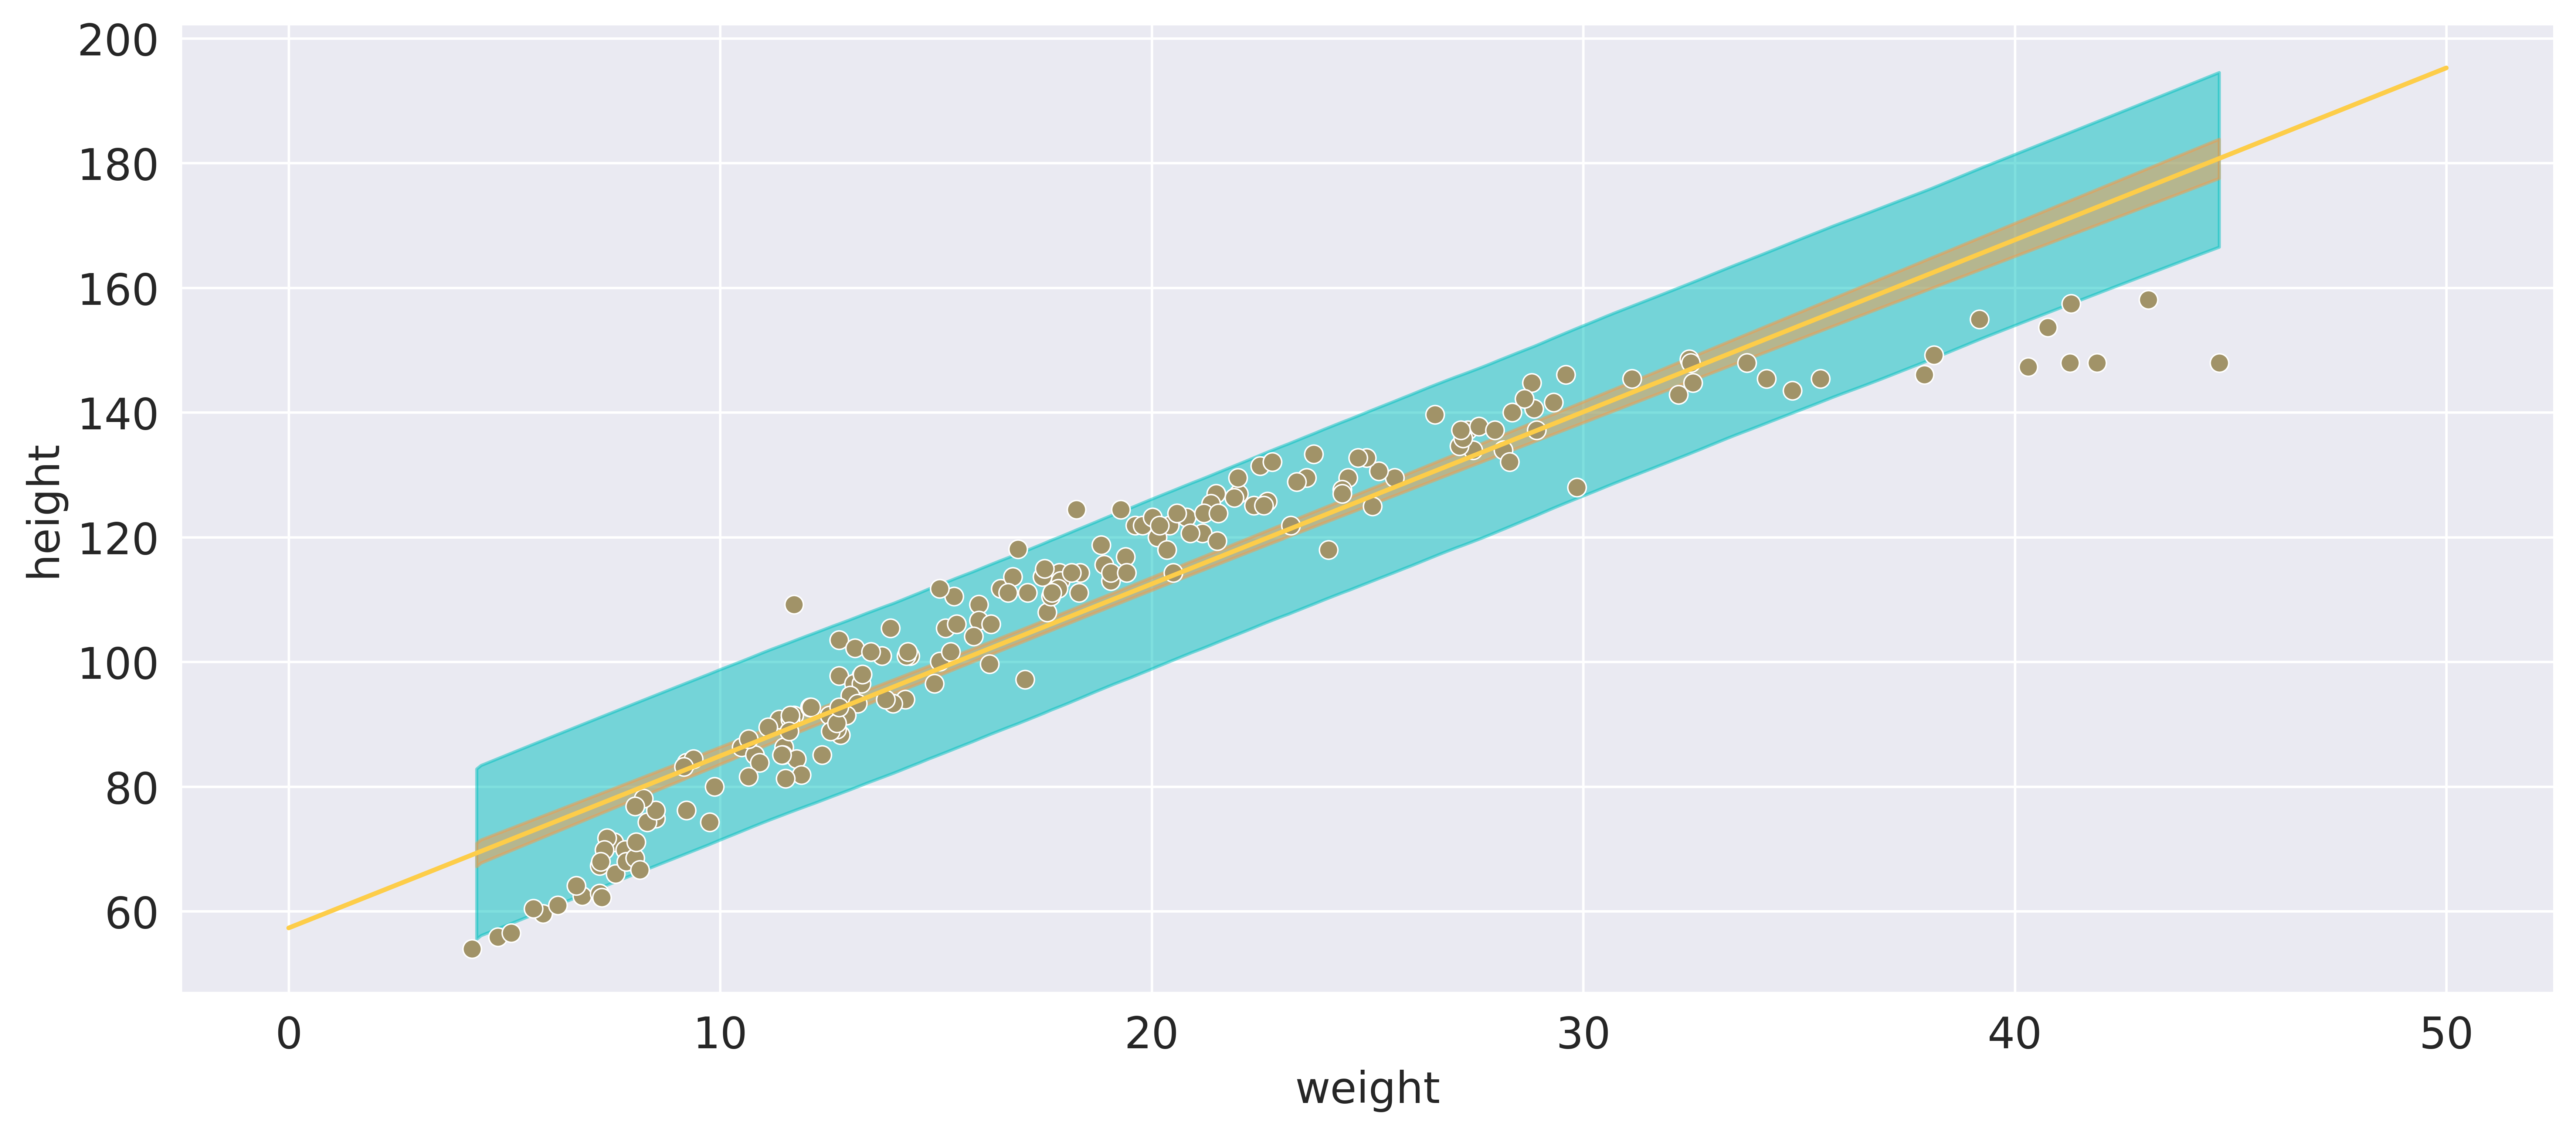

In [101]:
weight_seq = np.linspace(0, 50, 100)
mu_MAP = mean_q["alpha"] + mean_q["beta"]*weight_seq

ax = az.plot_hdi(df2.weight, post_pred.posterior_predictive["y"])
az.plot_hdi(df2.weight, idata.posterior["mu"], ax=ax, color="C2")
sns.scatterplot(data=df2, x="weight", y="height", ax=ax, color="C5")
plt.plot(weight_seq, mu_MAP, color="C3");

### 4H3

In [118]:
df["log_weight"] = np.log(df.weight)

In [192]:
from pytensor import tensor as T

with pm.Model() as m4H3:
    log_weight = pm.MutableData("log_weight", df.log_weight)
    height = pm.MutableData("height", df.height)
    alpha = pm.Normal("alpha", mu=178, sigma=20)
    beta = pm.LogNormal("beta", mu=0, tau=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = alpha + beta*(log_weight - log_weight.mean())
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=height, shape=log_weight.shape)
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [194]:
print(mean_q)

{'alpha': array(138.71589621), 'beta_log__': array(3.8203377), 'sigma_interval__': array(13.42010039), 'beta': array(45.61961132), 'sigma': array(49.99992575)}


Sampling: [y]


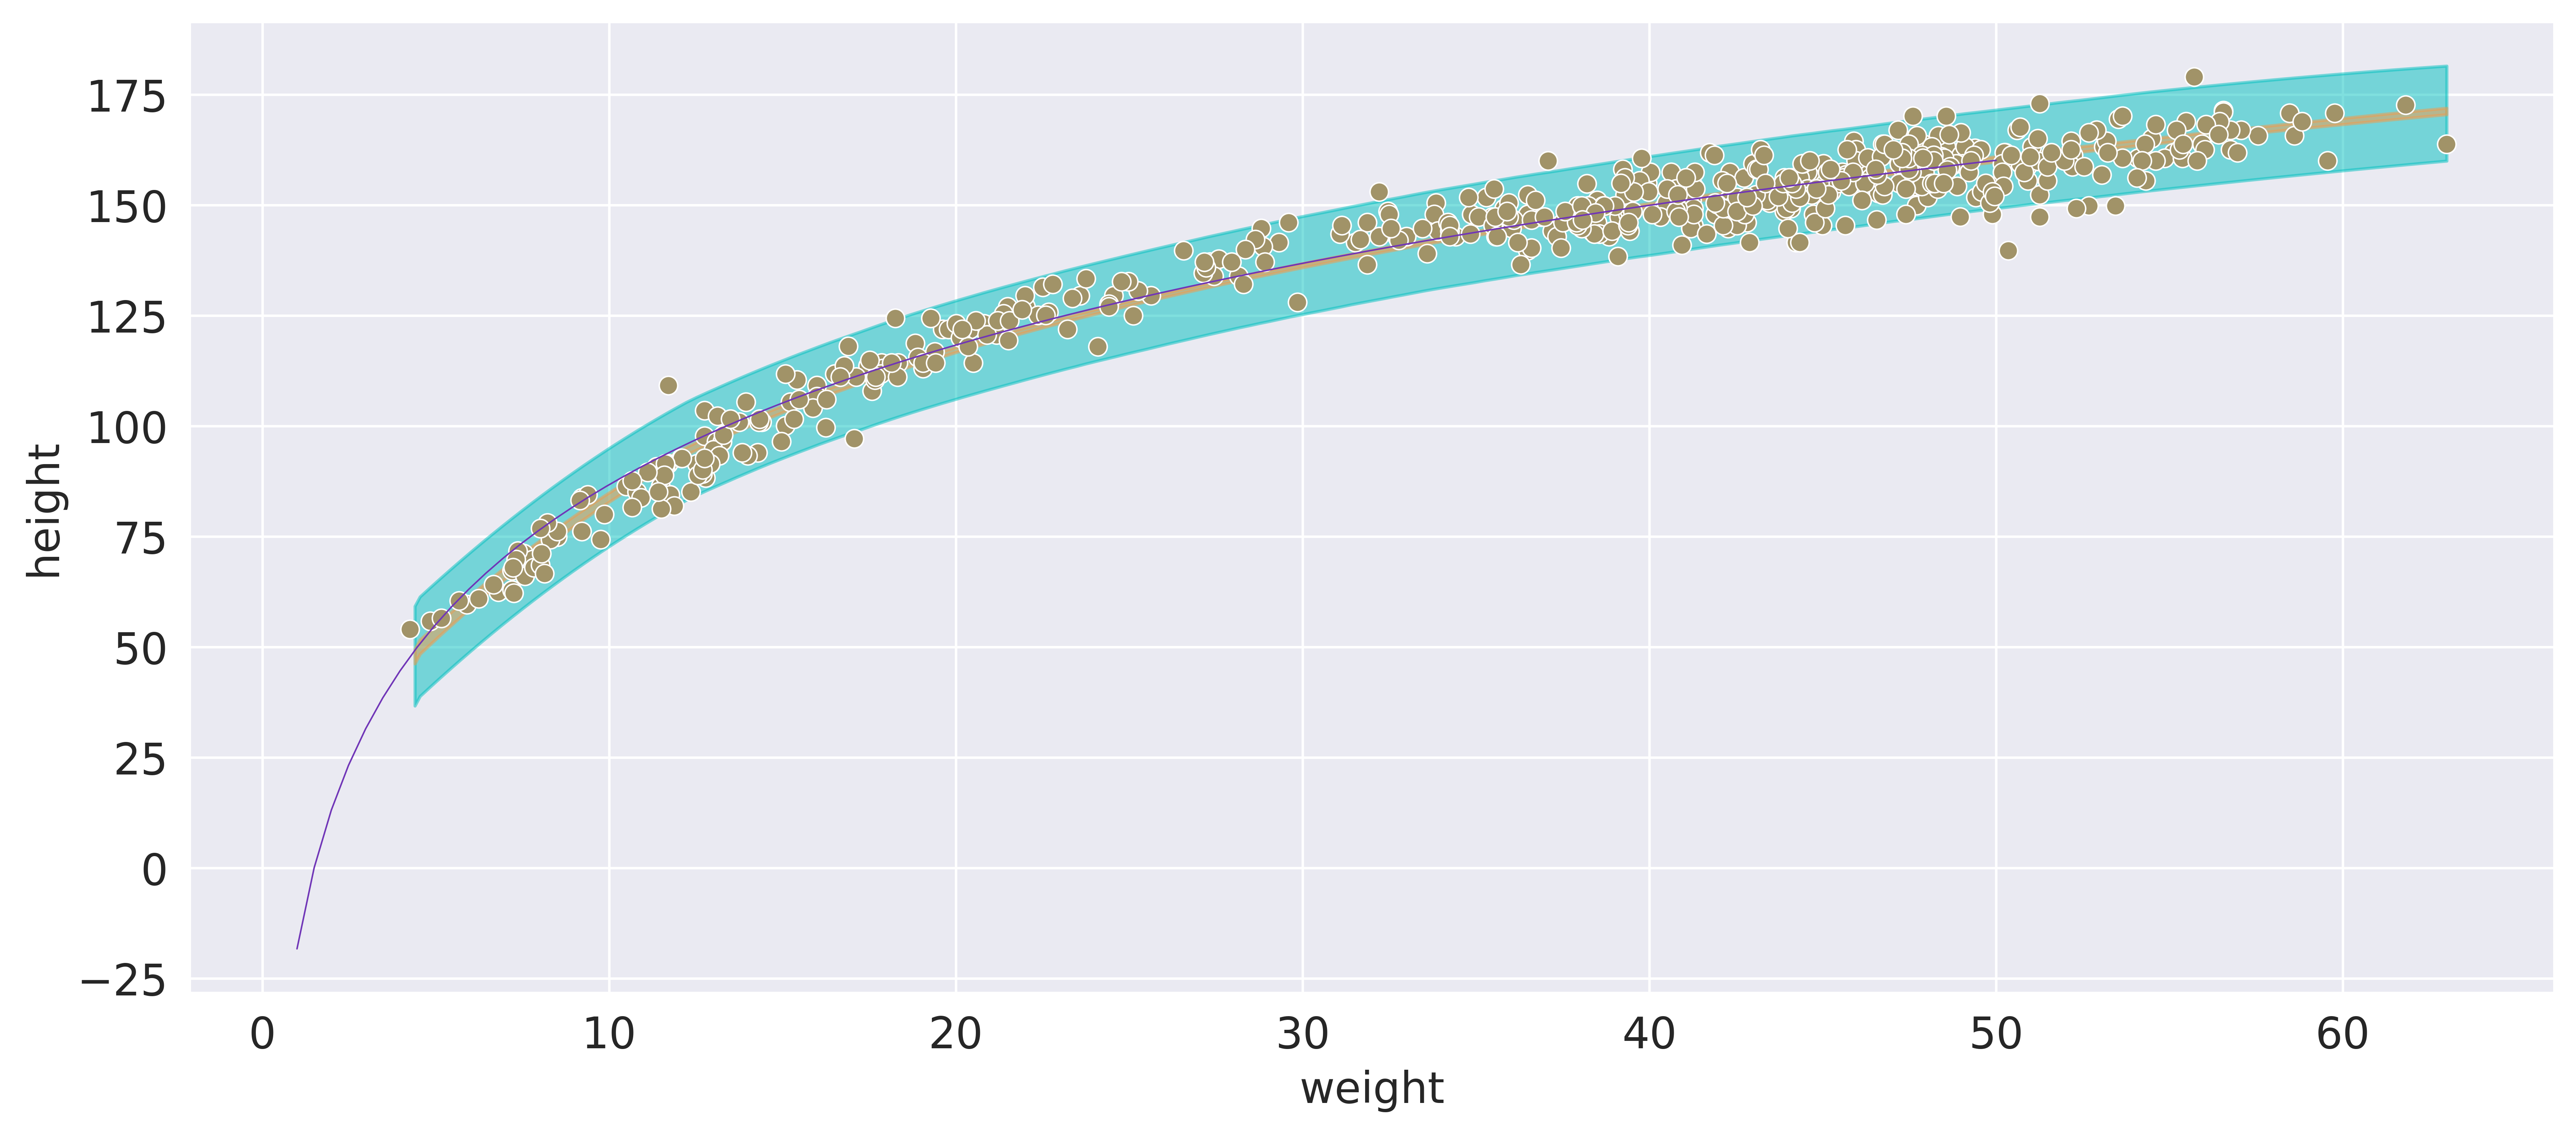

In [197]:
az.rcParams["stats.hdi_prob"] = 0.97

# plot hdi for post pred
with m4H3:
    post_pred = pm.sample_posterior_predictive(idata)
ax = az.plot_hdi(df.weight, post_pred.posterior_predictive["y"])

# plot hdi for post mean
post = idata.posterior
xr1, xr2 = xr.broadcast(post.beta, xr.DataArray(df.log_weight - df.log_weight.mean()))
mu_draws = post.alpha + xr1 * xr2
az.plot_hdi(df.weight, mu_draws, ax=ax, color="C2")

# plot input data
sns.scatterplot(data=df, x="weight", y="height", ax=ax, color="C5")

# plot MAP line
with m4H3:
    mean_q = pm.find_MAP()
weight_seq = np.linspace(1, 50, 100)
mu_MAP = mean_q["alpha"] + mean_q["beta"] * (np.log(weight_seq) - df.log_weight.mean())
plt.plot(weight_seq, mu_MAP, color="C8", linewidth=0.5);